# Imports

In [91]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

<font size='4'>Dependencies:</font>

python==3.9.13 \
requests==2.28.1 \
bs4==4.11.1 \
pandas==1.5.0 \
seaborn==0.12.0 \
matplotlib==3.6.0 \
numpy==1.23.3 \
sklearn==1.1.2

# Web Scraping

<font size='4'>*** This just creates the elo_data.csv and top_elo_data.csv so you don't need to run it ***</font>

In [23]:
# Retrieves all the URL's and names of Countries

URL = "https://footballdatabase.com/ranking/germany/1"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
countries = soup.find_all("option")[8:]
url_names = []
pretty_names = []
for country in countries:
    pretty_names.append(country.text)
    url_names.append(str(country).split('"')[1])

In [24]:
# Sends GET request for HTML and parses it for Team names and ELO ratings to Create Pandas DataFrame

team_df = []
for index, name in enumerate(url_names):
    URL = "https://footballdatabase.com" + name
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")

    ranks = soup.find_all("td", class_="rank")
    ranks = [rank.text for index, rank in enumerate(ranks) if index % 2 != 0]

    teams_html = soup.find_all("td", class_="club text-left")
    teams = []
    for team in teams_html:
        teams.append(team.find("div", class_="limittext").text)
    if len(ranks) != len(teams): # check if there is a team without a ELO or vice versa
        print("Error")
        print(ranks)
        print(teams)
        print(name)

    final_output = []
    for index2 in range(len(teams)):
        final_output.append([teams[index2], ranks[index2]]) # [['man city', 1942], ['team_name', 1454']]

    if 'Manchester City' in final_output[0] and pretty_names[index] != 'England': # some countries don't work and just default to the world list
        pass
    else:
        for pair in final_output:
            team_df.append([pretty_names[index], pair[0], pair[1]])

In [25]:
df = pd.DataFrame(team_df)
df.rename(columns={0: "country_name", 1: "team", 2: "elo"}, inplace=True)

In [27]:
df.to_csv("OUTPUTFILE/elo_data.csv", index=False)

In [28]:
elo_data_group = df[['country_name', 'elo']]
elo_data_group = elo_data_group.groupby(by='country_name').first().sort_values(by='elo', ascending=False)
elo_data_reset = elo_data_group.reset_index()
elo_data_reset.to_csv("OUTPUTFILE/top_elo_data.csv", index=False)

# Visualizations

<font size='4'>Top 10 vs Bottom 10</font>

In [92]:
elo_data = pd.read_csv("OUTPUTFILE/elo_data.csv")

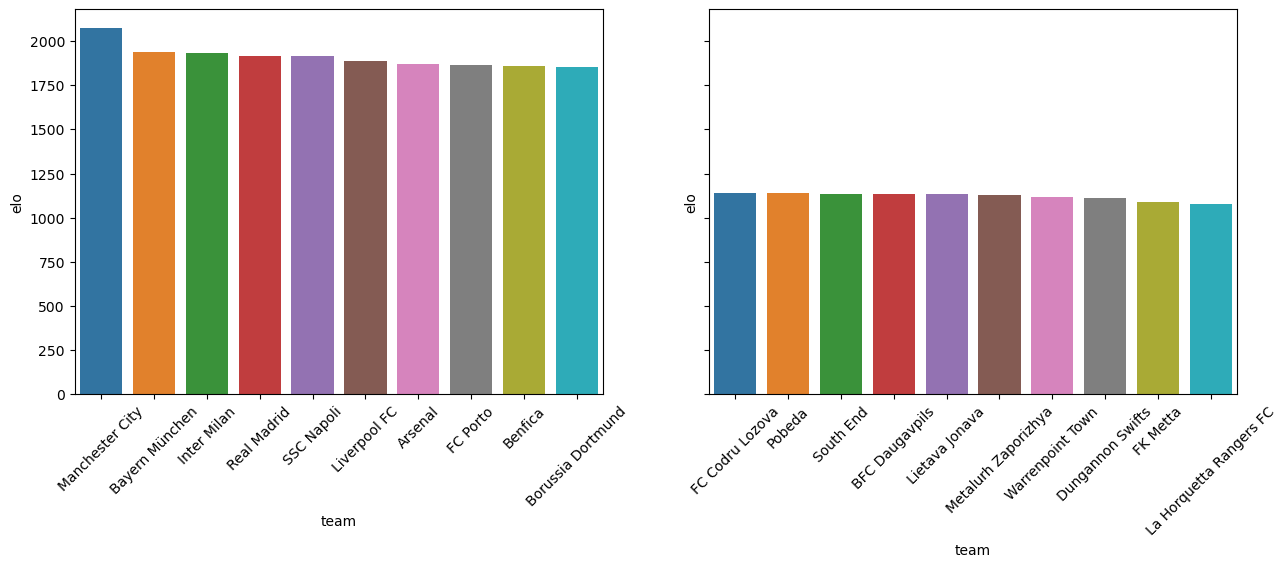

In [93]:
top_10 = elo_data.sort_values(by='elo', ascending=False).iloc[:10]
bottom_10 = elo_data.sort_values(by='elo', ascending=False).iloc[-10:]

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
plot = sns.barplot(ax=axes[0], data=top_10, x='team', y='elo')
for item in plot.get_xticklabels():
    item.set_rotation(45)
plot2 = sns.barplot(ax=axes[1], data=bottom_10, x='team', y='elo')
for item in plot2.get_xticklabels():
    item.set_rotation(45)

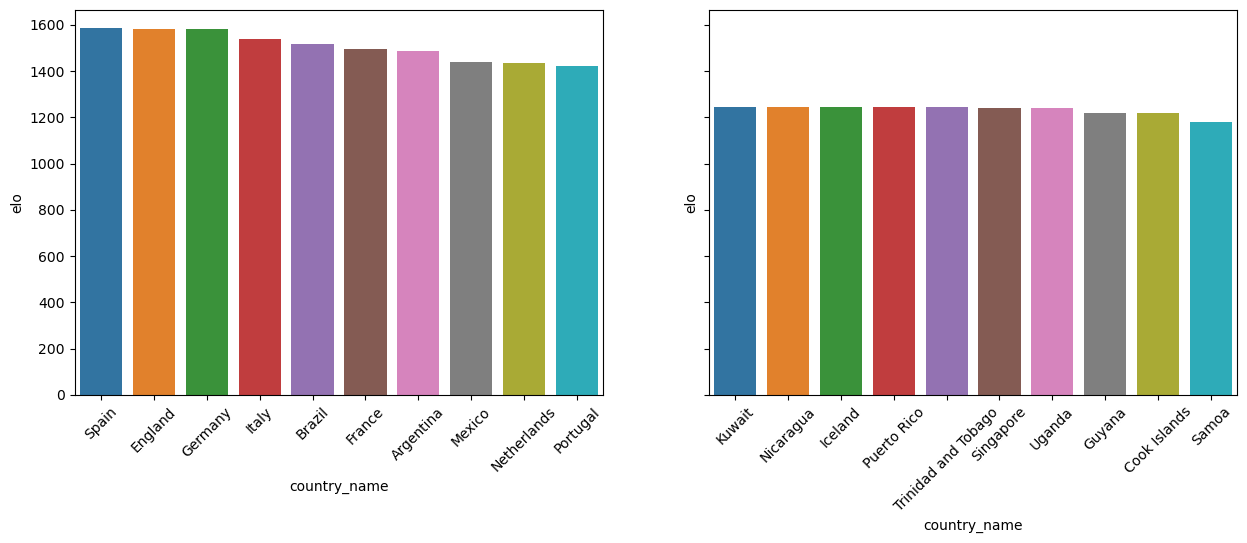

In [94]:
elo_data_group = elo_data[['country_name', 'elo']]
elo_data_group = elo_data_group.groupby(by='country_name').mean().sort_values(by='elo', ascending=False)
elo_data_group_top = elo_data_group.iloc[:10]
elo_data_group_bottom = elo_data_group.iloc[-10:]


fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
plot = sns.barplot(ax=axes[0], data=elo_data_group_top, x=elo_data_group_top.index, y='elo')
plot2 = sns.barplot(ax=axes[1], data=elo_data_group_bottom, x=elo_data_group_bottom.index, y='elo')
for item in plot.get_xticklabels():
    item.set_rotation(45)
for item in plot2.get_xticklabels():
    item.set_rotation(45)

<font size='5'>Correlation of ELO and Power_rating (World Cup results score)</font>

In [95]:
wc_df = pd.read_csv('OUTPUTFILE/world_cup_result.csv')

In [96]:
elo_data_reset = elo_data_group.reset_index()
merged_df = wc_df.merge(elo_data_reset, on='country_name')

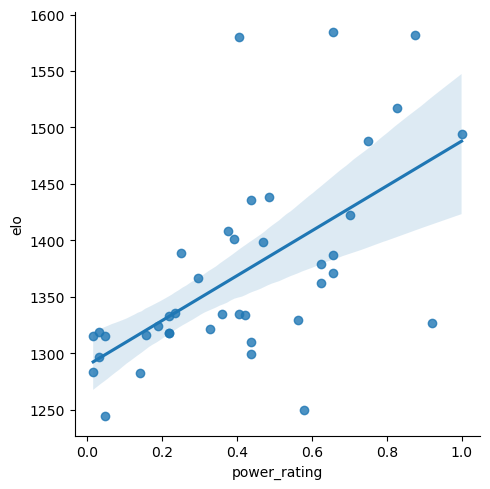

In [97]:
sns.lmplot(data=merged_df, y='elo', x='power_rating')

In [98]:
corr_df = merged_df[['elo', 'power_rating']]
corr_df.corr()

,elo,power_rating
elo,1.000000,0.611692
power_rating,0.611692,1.000000


In [99]:
corr_df = merged_df[['elo', 'power_rating']]
corr_df.corr()

,elo,power_rating
elo,1.000000,0.611692
power_rating,0.611692,1.000000


<font size='5'>Outlier Analysis</font>

In [100]:
merged_df['power_rank'] = merged_df['power_rating'].rank(ascending=False)
merged_df['elo_rank'] = merged_df['elo'].rank(ascending=False)
merged_df['diff'] = merged_df.apply(lambda x : x['elo_rank'] - x['power_rank'], axis=1)
merged_df = merged_df.sort_values(by='diff', ascending=False)


In [101]:
x = merged_df['power_rating'].values.reshape(-1,1)
regression_model = LinearRegression()
regression_model.fit(x, merged_df['elo'])
p1 = np.array([0, float(regression_model.intercept_ + 0*regression_model.coef_)])
p2 = np.array([1, float(regression_model.intercept_ + 1*regression_model.coef_)])

def distance_func(power, elo):
    p3 = np.array([power, elo])
    return np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)


merged_df['distance'] = merged_df.apply(lambda x : distance_func(x['power_rating'], x['elo']), axis=1)
merged_df = merged_df.sort_values(by='distance', ascending=False)

In [102]:
merged_df['signed_dist'] = merged_df.apply(lambda x : x['distance'] if x['diff'] > 1 else -x['distance'], axis=1)
merged_df = merged_df.sort_values(by='signed_dist', ascending=False)
merged_df_top = merged_df[:3]
merged_df_bottom = merged_df[-3:]
final_df = pd.concat([merged_df_top, merged_df_bottom])
final_df

,Unnamed: 0,country_name,power_rating,elo,power_rank,elo_rank,diff,distance,signed_dist
30,30,Senegal,0.578125,1249.500000,12.0,39.0,27.0,0.777929,0.777929
8,8,Croatia,0.921875,1326.380952,2.0,25.0,23.0,0.734588,0.734588
9,9,Denmark,0.437500,1299.636364,17.0,35.0,18.0,0.384875,0.384875
12,12,England,0.875000,1581.425000,3.0,2.0,-1.0,0.596405,-0.596405
33,33,Spain,0.656250,1584.944444,8.0,1.0,-7.0,0.832872,-0.832872
14,14,Germany,0.406250,1580.300000,20.5,3.0,-17.5,1.059484,-1.059484


Text(0, 0.5, 'Country')

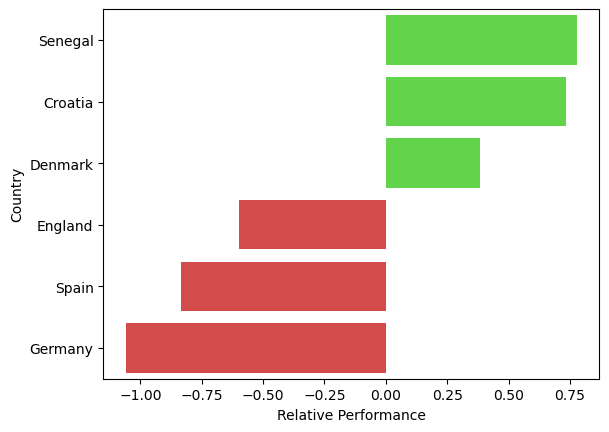

In [103]:
colors = ["#52eb34", "#52eb34", "#52eb34","#eb3434","#eb3434","#eb3434"]
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=final_df, y='country_name', x='signed_dist')
plt.xlabel('Relative Performance')
plt.ylabel('Country')

In [104]:
# reset seaborn color palette
matplotlib.rc_file_defaults()

In [105]:
wc_result = pd.read_csv('OUTPUTFILE/world_cup_result.csv').drop(columns=['Unnamed: 0'])
elo = pd.read_csv('OUTPUTFILE/top_elo_data.csv')
secondary = pd.read_csv('OUTPUTFILE/SECONDARY_INDICATORS_AGG.csv').drop(columns=['power_rating'])
value = pd.read_csv('OUTPUTFILE/avg_league_val_by_country.csv').drop(columns=['Unnamed: 0'])
foreign = pd.read_csv('OUTPUTFILE/foreign_player_national_teams_agg.csv').drop(columns=['Unnamed: 0'])

In [106]:
final_df = pd.merge(pd.merge(pd.merge(pd.merge(wc_result, elo,on='country_name'), secondary, on='country_name'), value, on='country_name'), foreign, on='country_name')

In [107]:
from itertools import combinations

choices = ['elo', 'gdp_usd','mv_usd','bmi','life_exp','qol','market_val','mv_play_dom','num_play_dom','mv_play_int','num_play_int','dom_int_mv_ratio']
list_combinations = []

for n in range(1, len(choices) + 1):
    list_combinations += list(combinations(choices, n))

final_list = []
for option in list_combinations:
    final_list.append(list(option))

In [108]:
lists = []
for combo in final_list:
    X = final_df[combo]
    y = final_df['power_rating']
    regr = LinearRegression()
    regr.fit(X,y)

    r_2 = regr.score(X,y)
    lists.append([combo, float(r_2)])
df = pd.DataFrame(lists, columns=['combo', 'r_2'])
df['3'] = df.apply(lambda x : len(x['combo']), axis=1)
df = df.sort_values(by='r_2', ascending=False)

In [109]:
df = df.groupby(by=['3']).first().reset_index()
for index, item in df.iterrows():
    print(f"{item['r_2']},   {item['combo']}")

0.4227924312440102,   ['mv_play_int']
0.5482762693739822,   ['qol', 'mv_play_int']
0.5767609287910678,   ['elo', 'qol', 'mv_play_int']
0.6224074025706908,   ['elo', 'mv_usd', 'market_val', 'mv_play_dom']
0.6632644643065269,   ['elo', 'mv_usd', 'qol', 'market_val', 'mv_play_dom']
0.6735830896906242,   ['elo', 'gdp_usd', 'mv_usd', 'qol', 'market_val', 'mv_play_dom']
0.6763479180721002,   ['elo', 'gdp_usd', 'mv_usd', 'qol', 'market_val', 'mv_play_dom', 'num_play_dom']
0.6776947319753828,   ['elo', 'gdp_usd', 'mv_usd', 'qol', 'market_val', 'mv_play_dom', 'num_play_dom', 'num_play_int']
0.6783507265887705,   ['elo', 'gdp_usd', 'mv_usd', 'bmi', 'qol', 'market_val', 'mv_play_dom', 'num_play_dom', 'num_play_int']
0.6792013210637374,   ['elo', 'gdp_usd', 'mv_usd', 'bmi', 'qol', 'market_val', 'mv_play_dom', 'num_play_dom', 'num_play_int', 'dom_int_mv_ratio']
0.6793292020730597,   ['elo', 'gdp_usd', 'mv_usd', 'bmi', 'life_exp', 'qol', 'market_val', 'mv_play_dom', 'num_play_dom', 'num_play_int', '